# Outlier Detection and Visualization with Voronoi Diagrams
This notebook demonstrates how to use Voronoi diagrams and LOF (Local Outlier Factor) to analyze spatial outliers in movement data from a synthetic playground dataset. It uses the `graphsd` library to compute features and visualize results.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from graphsd.outlier import OutlierSDMining, voronoi_finite_polygons_2d
from graphsd.datasets import load_data
from graphsd.utils import make_bins
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

## Load and Preprocess Data
We load synthetic position and social interaction data, parse timestamps, and bin the social features into quantiles for analysis.

In [2]:
position_data, social_df = load_data("playground_a")
position_data["time"] = pd.to_datetime(position_data["time"])
social_df = make_bins(social_df, n_bins=3, strategy="quantile")

## Compute Voronoi Areas and LOF
We initialize the `OutlierSDMining` class and compute Voronoi cell areas and Local Outlier Factor (LOF) scores over time windows.

In [3]:
miner = OutlierSDMining()
area_df = miner.get_voronoi_areas(position_data, social_df, time_step=1)
lof_df = OutlierSDMining.get_lof(position_data, social_df, time_step=1)
merged = pd.merge(lof_df, area_df, on=["id", "timestamp"], how="outer")

## Normalize and Plot Mean Values
We compute the average LOF and Voronoi area per individual, normalize both for comparison, and create a grouped bar chart.

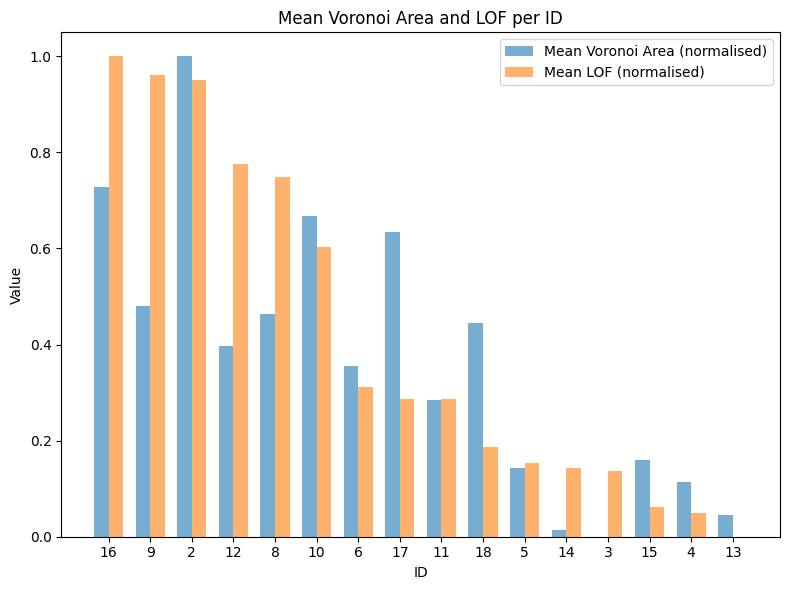

In [6]:
plt.figure(figsize=(8, 6))

means = merged.groupby("id")[["area", "lof"]].mean().reset_index()
scaler = MinMaxScaler()
means[["area_norm", "lof_norm"]] = scaler.fit_transform(means[["area", "lof"]])
means = means.sort_values(by="lof_norm", ascending=False).reset_index(drop=True)

width = 0.35
x = np.arange(len(means["id"]))

plt.bar(x - width / 2, means["area_norm"], width, alpha=0.6, label="Mean Voronoi Area (normalised)")
plt.bar(x + width / 2, means["lof_norm"], width, alpha=0.6, label="Mean LOF (normalised)")

ax = plt.gca()  # get current axes
ax.set_xticks(x)
ax.set_xticklabels(means["id"])
ax.set_title("Mean Voronoi Area and LOF per ID")
ax.set_xlabel("ID")
ax.set_ylabel("Value")
ax.legend()

plt.tight_layout()
plt.show()

## Snapshot Visualization with Voronoi Overlay
We pick a random timestamp and visualize player positions at that moment. We also compute and overlay the corresponding Voronoi diagram, shading regions by area size.

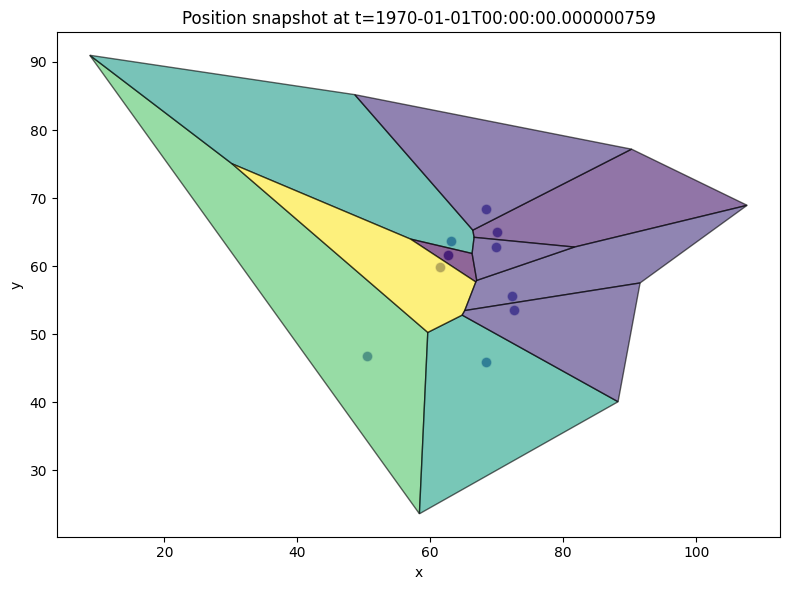

In [7]:
# Create a new figure and axes
plt.figure(figsize=(8, 6))

# Random snapshot of positions
random_ts = position_data["time"].sample(1, random_state=0).values[0]
snapshot = position_data[position_data["time"] == random_ts]

# Plot the positions
plt.scatter(snapshot["x"], snapshot["y"], alpha=0.7, color="darkblue", edgecolor="white", s=60)

try:
    points = snapshot[["x", "y"]].values
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    areas = miner.compute_voronoi_areas(points)

    norm = colors.Normalize(vmin=min(areas), vmax=max(areas))
    cmap = plt.get_cmap("viridis")

    for i, region in enumerate(regions):
        polygon = vertices[region]
        poly = Polygon(np.append(polygon, [polygon[0]], axis=0))
        if not poly.is_valid:
            continue
        x, y = poly.exterior.xy
        plt.fill(x, y, alpha=0.6, edgecolor="black", facecolor=cmap(norm(areas[i])))

except Exception as e:
    print(f"Could not overlay Voronoi diagram: {e}")

# Set labels and title
ax = plt.gca()
ax.set_title(f"Position snapshot at t={random_ts}")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.tight_layout()
plt.show()